In [2]:
#!imports
import sys
from pathlib import Path


import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
sns.set_theme()
import numpy as np
import random
import torch

from dagnosis.data.datamodule import SyntheticData
from dagnosis.utils.data import sample_corrupted

from dagnosis.utils.seed import set_random_seeds


seed = 42
set_random_seeds(seed)

d = 4
n_train = 1000
n_test = 10000
s = d-1

sem_type = "mlp"
graph_type = "chain"
batch_size = n_train


data_config_train={
    "dim": d,
    "s0": s, 
    "n_train": n_train,
    "n_test": n_test,
    "sem_type": sem_type,
    "dag_type": graph_type,
    "batch_size": batch_size,
}



D = SyntheticData(**data_config_train)
D.setup()

X_train = D.get_train()
X_test_clean = D.get_test()



    

DAGNOSIS GT


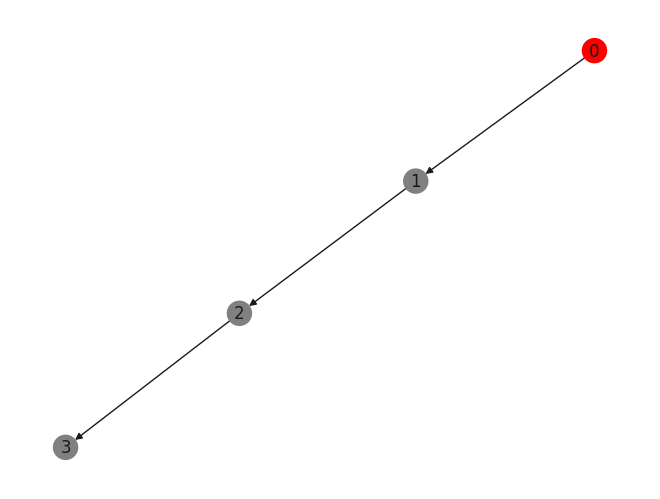

  0%|          | 0/4 [00:00<?, ?it/s]

DATA SUITE


100%|██████████| 4/4 [00:07<00:00,  1.96s/it]


In [ ]:

from dagnosis.utils.plotting import plot_graph
from dagnosis.conformal.significance_correction import BonferroniCorrection
from dagnosis.conformal.conformal_evaluator import ConformalEvaluator
from dagnosis.representation.representation_mapper import DAGRepresentationMapper, PCARepresentationMapper
from dagnosis.dag_learner.extractor import GroundTruthDAG

from omegaconf import OmegaConf

conf_predictor_dict = {
    "_target_": "dagnosis.conformal.conformal_predictor.CQR",
    "scale": False,
    "seed": seed,
    "cal_size": 0.2,
    "n_search": 100,
    "param_bounds": {
        "num_leaves": {
            "low": 10,
            "high": 50
        },
        "max_depth": {
            "low": 3,
            "high": 20
        },
        "n_estimators": {
            "low": 50,
            "high": 300
        },
        "learning_rate": {
            "low": 0,
            "high": 1
        }
    },
    "n_splits": 5
}
conf_predictor_cfg = OmegaConf.create(conf_predictor_dict)
alpha = 0.1 


print("DAGNOSIS GT")

conformal_evaluator_dag = ConformalEvaluator(conf_predictor_cfg=conf_predictor_cfg)
dag_extractor = GroundTruthDAG()
A_gt = dag_extractor.extract(data = D)
dag_representation = DAGRepresentationMapper()
dag_representation.set_dag(A_gt)
dag_representation.fit(X_train)
plot_graph(A_gt, 0)
list_features = np.arange(d)
alphas_adjusted = BonferroniCorrection().compute_correction(significance=alpha, list_of_features=list_features)
conformal_evaluator_dag.train(X_train = X_train, representation_mapper=dag_representation, list_features=list_features, alphas_adjusted=alphas_adjusted)



print("DATA SUITE")
conformal_evaluator_pca = ConformalEvaluator(conf_predictor_cfg=conf_predictor_cfg)
pca_mapper = PCARepresentationMapper(random_state=0, compression_factor=0.5)
pca_mapper.fit(X_train)

conformal_evaluator_pca.train(X_train = X_train, representation_mapper=pca_mapper, list_features=list_features, alphas_adjusted=alphas_adjusted)

In [4]:
n_corrupted = 10000
list_TPR_gain = []


# only corrupt the last feature
list_features_corruption = np.array([d-1])
list_corruption_type = ["gaussian_noise"]*len(list_features_corruption)

print("Corrupted nodes: {}".format(list_features_corruption))

noise_mean_list = np.zeros(d)
X_test_corrupted, list_corrupted_SEMs, list_corrupted_parameters =sample_corrupted(D, n_corrupted, list_features_corruption, list_corruption_type, noise_mean_list=noise_mean_list, sample_last_layer=False, std_mlp = 2, mean_mlp =0)
# Compute the predictions, and then compute the metrics

conf_dict_gt = conformal_evaluator_dag.predict(
    X_test_corrupted, list_features=list_features
)

conf_dict_pca = conformal_evaluator_pca.predict(
    X_test_corrupted, list_features=list_features
)


Corrupted nodes: [3]


In [5]:
# We compute, for each inconsistent samples, on how many features it was flagged
n_indices_flagged_list_dn = []
for row in range(len(X_test_corrupted)):
    n_indices_flagged = 0
    for feature in range(d):
        if not (conf_dict_gt[feature].iloc[row]["min"] <= conf_dict_gt[feature].iloc[row]["true_val"] <= conf_dict_gt[feature].iloc[row]["max"]):
            n_indices_flagged +=1
    if n_indices_flagged >0:
        #flagged at least on one feature
        n_indices_flagged_list_dn.append(n_indices_flagged)
print(f"DAGNOSIS: On average, the inconsistent samples were flagged on {np.mean(n_indices_flagged_list_dn)} features")
print(f"Std: {1.96*np.std(n_indices_flagged_list_dn)/np.sqrt(len(n_indices_flagged_list_dn))}")

        

DAGNOSIS: On average, the inconsistent samples were flagged on 1.0498 features
Std: 0.00452585857419341


In [6]:
n_indices_flagged_list_datasuite = []
for row in range(len(X_test_corrupted)):
    n_indices_flagged = 0
    for feature in range(d):
        if not (conf_dict_pca[feature].iloc[row]["min"] <= conf_dict_pca[feature].iloc[row]["true_val"] <= conf_dict_pca[feature].iloc[row]["max"]):
            n_indices_flagged +=1
    if n_indices_flagged >0:
        #flagged at least on one feature
        n_indices_flagged_list_datasuite.append(n_indices_flagged)
print(f"Data-SUITE: On average, the inconsistent samples were flagged on {np.mean(n_indices_flagged_list_datasuite)} features")
print(f"Std:{1.96*np.std(n_indices_flagged_list_datasuite)/np.sqrt(len(n_indices_flagged_list_datasuite))}")

Data-SUITE: On average, the inconsistent samples were flagged on 3.265 features
Std:0.014687908360280576
